<a href="https://colab.research.google.com/github/trustyuke/BE562_Project/blob/main/Lung_TMB_Analylsis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the data from github 
It contains the data downloaded from https://www.cbioportal.org/study/summary?id=luad_mskcc_2020.It contains targeted sequencing of 604 lung adenocarcinoma tumor/normal pairs via MSK-IMPACT.

In [1]:
!git clone https://github.com/trustyuke/BE562_Project


Cloning into 'BE562_Project'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 12), reused 4 (delta 1), pack-reused 0
Unpacking objects: 100% (33/33), done.


In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#MLP classifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

# MLP regression
from sklearn.neural_network import MLPRegressor

from sklearn import metrics

import math



### Load the Lung Dataset


In [3]:
# Load the dataset
Lung = pd.read_csv("BE562_Project/Lung.csv")
# Find number of missing value for each column 
Lung.isna().sum()
Lung = Lung.dropna()

In [4]:
# Convert Survival_Status to a binary variable with 0 representing deceased and 1 representing living 
def convert_RFS(row):
  if row.RFS_STATUS == '1:Recurrence':
    return 1
  else:
    return 0 
Lung['RFS'] = Lung.apply(convert_RFS, axis='columns')
def convert_Gender(row):
  if row.SEX == "Male":
    return 0
  elif row.SEX == "Female":
    return 1 
Lung['Gender_binary'] = Lung.apply(convert_Gender, axis='columns')
def convert_CN(row):
  if row.CN_STATUS == 'Negative':
    return 0
  else:
    return 1 
Lung['CN'] = Lung.apply(convert_CN, axis='columns')
lung_TMB_cutoff = Lung.TMB_NONSYNONYMOUS.describe()['75%']
def convert_TMB(row):
  if row.TMB_NONSYNONYMOUS < lung_TMB_cutoff:
    return 0
  else:
    return 1
Lung['TMB_HIGH_LOW'] = Lung.apply(convert_TMB, axis='columns')
  

<ipython-input-4-7d832c60d6d3>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lung['RFS'] = Lung.apply(convert_RFS, axis='columns')
<ipython-input-4-7d832c60d6d3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Lung['Gender_binary'] = Lung.apply(convert_Gender, axis='columns')
<ipython-input-4-7d832c60d6d3>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

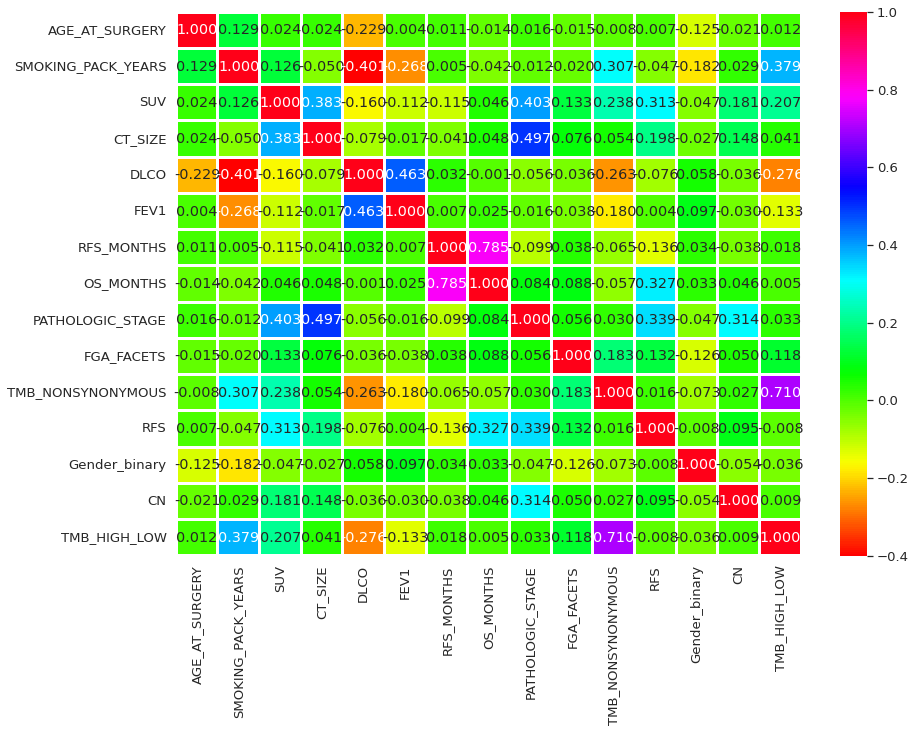

In [5]:
import seaborn as sns
sns.set(font_scale=1.2)
plt.figure(figsize=(14,10))
sns.heatmap(Lung.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()

###Classification for lung dataset

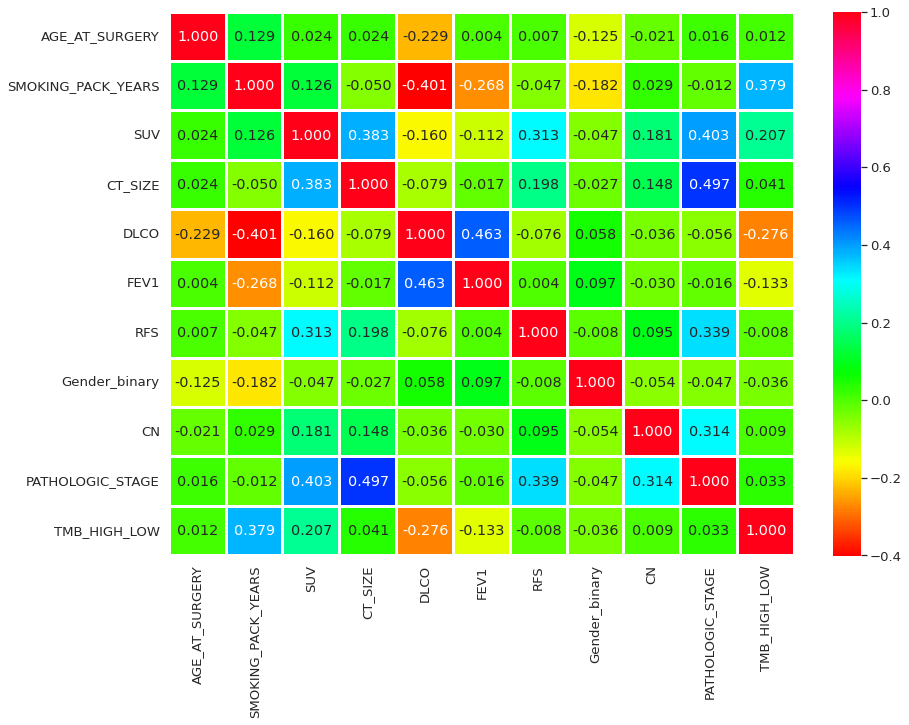

0    381
1    136
Name: TMB_HIGH_LOW, dtype: int64

In [6]:
Lung_Clinical_C= Lung[["AGE_AT_SURGERY","SMOKING_PACK_YEARS","SUV","CT_SIZE","DLCO","FEV1","RFS","Gender_binary","CN","PATHOLOGIC_STAGE","TMB_HIGH_LOW"]]
#Lung_Clinical_C= Lung[["AGE_AT_SURGERY","SMOKING_PACK_YEARS","SUV","CT_SIZE","DLCO","FEV1","TMB_NONSYNONYMOUS","Gender_binary","CN","RFS"]]
plt.figure(figsize=(14,10))
sns.heatmap(Lung_Clinical_C.corr(),annot=True,cmap='hsv',fmt='.3f',linewidths=2)
plt.show()
Lung_Clinical_C.TMB_HIGH_LOW.value_counts()

__Use MLP Classifers__

In [7]:
# Split the data into training and test set
y = Lung_Clinical_C.TMB_HIGH_LOW.to_numpy()
X = Lung_Clinical_C.iloc[:,:10].to_numpy()
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)
print(X_train.shape)
print(X_test.shape)


sc=StandardScaler()
scaler = sc.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


(517, 10)
(413, 10)
(104, 10)


In [8]:
mlp_clf = MLPClassifier(hidden_layer_sizes=(20,9),
                        max_iter = 300,activation = 'relu',
                        solver = 'adam',
                        learning_rate = 'adaptive')

mlp_clf.fit(X_train_scaled, y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(hidden_layer_sizes=(20, 9), learning_rate='adaptive',
              max_iter=300)

Accuracy: 0.740
              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.50      0.37      0.43        27

    accuracy                           0.74       104
   macro avg       0.65      0.62      0.63       104
weighted avg       0.72      0.74      0.73       104



[Text(0, 0.5, 'TMB-LOW'), Text(0, 1.5, 'TMB-HIGH')]

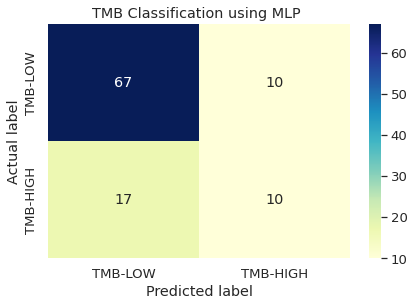

In [9]:
y_pred = mlp_clf.predict(X_test_scaled)

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))
# fig = plot_confusion_matrix(mlp_clf, X_test_scaled, y_test, display_labels=mlp_clf.classes_)
# fig.figure_.suptitle("Confusion Matrix for Lung TMB")
# plt.show()
print(classification_report(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


class_names=["TMB-LOW","TMG-HIGH"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('TMB Classification using MLP ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

ax.xaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])
ax.yaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])

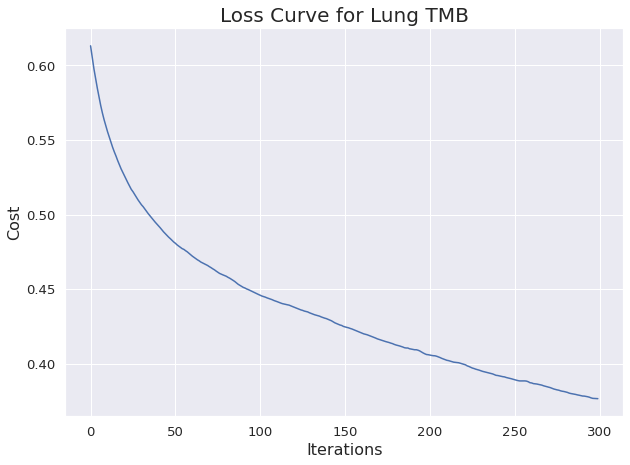

In [10]:
plt.figure(figsize=(5*2,3.57*2))
plt.plot(mlp_clf.loss_curve_)
plt.title("Loss Curve for Lung TMB", fontsize=20)
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Cost', fontsize=16)
plt.show()

In [11]:
# param_grid = {
#     'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
#     'max_iter': [50, 100, 150],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# grid = GridSearchCV(mlp_clf, param_grid, n_jobs= -1, cv=5)
# grid.fit(X_train_scaled, y_train)

# print(grid.best_params_) 
# grid_predictions = grid.predict(X_test_scaled) 

# print('Accuracy: {:.2f}'.format(accuracy_score(y_test, grid_predictions)))

__Logistic Regression__

Logistic Regression Accuracy: 79.81


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Text(0, 0.5, 'TMB-LOW'), Text(0, 1.5, 'TMB-HIGH')]

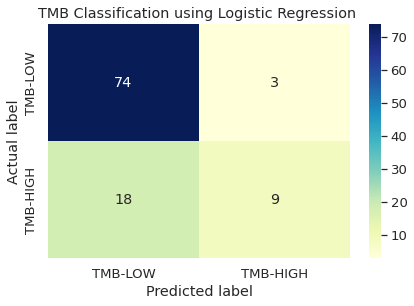

In [12]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=60)
logreg.fit(X_train,y_train)
y_pred=logreg.predict(X_test)
accuracy_lr = round(metrics.accuracy_score(y_test,y_pred)*100,2)
print("Logistic Regression Accuracy:",accuracy_lr)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


class_names=["TMB-LOW","TMG-HIGH"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('TMB Classification using Logistic Regression ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

ax.xaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])
ax.yaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])


__Naive Bayes__

Gaussian NB Accuracy: 75.96


[Text(0, 0.5, 'TMB-LOW'), Text(0, 1.5, 'TMB-HIGH')]

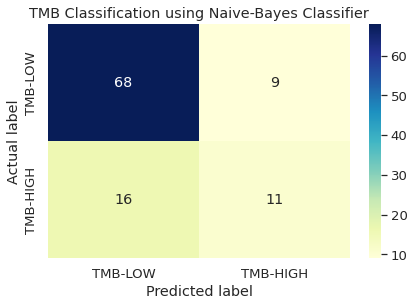

In [13]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train,y_train)
y_pred=model.predict(X_test)
accuracy_gnb = round(metrics.accuracy_score(y_test,y_pred)*100,2)
print("Gaussian NB Accuracy:",accuracy_gnb)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)


class_names=["TMB-LOW","TMG-HIGH"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('TMB Classification using Naive-Bayes Classifier')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

ax.xaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])
ax.yaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])


__DecisionTreeClassifier__

In [14]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
parameters = {'max_features':['log2','sqrt','auto'],
             'criterion':['entropy','gini'],
             'max_depth':[2,3,5,10,50],
             'min_samples_split':[2,3,50,100],
             'min_samples_leaf':[1,5,8,10]}
grid_obj = GridSearchCV(clf,parameters)
grid_obj = grid_obj.fit(X_train,y_train)
clf = grid_obj.best_estimator_
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
accuracy_dt = round(metrics.accuracy_score(y_test,y_pred)*100,2)
print("Decision Tree Accuracy:",accuracy_dt)


Decision Tree Accuracy: 71.15


__SVM__

In [15]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)
# from sklearn import svm
# svc = svm.SVC()
# parameters = [
#   {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#   {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
# ]
# grid_obj = GridSearchCV(svc,parameters)
# grid_obj = grid_obj.fit(X_train,y_train)
# svc = grid_obj.best_estimator_
# svc.fit(X_train,y_train)
# y_pred = svc.predict(X_test)
# accuracy_svm = round(metrics.accuracy_score(y_test,y_pred)*100,2)
# print("SVM Accuracy:",accuracy_svm)

__Use PNN Classifier__

In [16]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [17]:
class Clinical_Dataset(Dataset):
  '''
  Prepare the Lung Clinical dataset for Classification 
  '''

  def __init__(self, X, y, scale_data=True):
    if not torch.is_tensor(X) and not torch.is_tensor(y):
      # Apply scaling if necessary
      if scale_data:
          X = StandardScaler().fit_transform(X)
      self.X = torch.from_numpy(X)
      self.y = torch.from_numpy(y)

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return self.X[i], self.y[i]

In [18]:
# Split the data into training and test set
y = Lung_Clinical_C.TMB_HIGH_LOW.to_numpy()
X = Lung_Clinical_C.iloc[:,:9].to_numpy()
print(X.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.2)
print(X_train.shape)
print(X_test.shape)


(517, 9)
(413, 9)
(104, 9)


In [20]:
train_dataset = Clinical_Dataset(X_train,y_train)
test_dataset = Clinical_Dataset(X_test,y_test)
# Creating Dataloaders    
trainloader = DataLoader(train_dataset, batch_size=59, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=104,shuffle = True)
#
print(X.shape)
TRAIN_SIZE = X_train.shape[0]
TEST_SIZE = X_test.shape[0]
print(X_train.shape)
print(X_test.shape)

(517, 9)
(413, 9)
(104, 9)


In [22]:
# Set up the hyperparameter 

# division of the dataset in batches of 59 data points 
BATCH_SIZE = 59
# 1 epoch = training with all batches in the dataset
TRAIN_EPOCHS = 100
# number of classes in the dataset
CLASSES = 2

# TOTAL_INPUT 
INPUT = 9

# number of times we will sample from the distribution of parameters
SAMPLES = 10
# these are needed for the mixture of Gaussians for the prior
PI = 0.5
# SIGMA1 = torch.cuda.FloatTensor([math.exp(-0)])
# SIGMA2 = torch.cuda.FloatTensor([math.exp(-6)])
SIGMA1 = torch.FloatTensor([math.exp(-0)])
SIGMA2 = torch.FloatTensor([math.exp(-6)])
NUM_BATCHES = len(trainloader)


In [23]:
# Define the BNN 
class BNN(nn.Module):
    
    def __init__(self, n_hidden=15, n_classes= CLASSES):
        super().__init__()
        self.l1 = BayesianLinear(9, n_hidden)
        self.l2 = BayesianLinear(n_hidden, n_hidden)
        self.l3 = BayesianLinear(n_hidden, n_hidden)
        self.l4 = BayesianLinear(n_hidden, n_classes)

    def forward(self, x, sample=False):
        x = x.view(-1, 9)
        x = F.relu(self.l1(x, sample))
        x = F.relu(self.l2(x, sample))
        x = F.relu(self.l3(x, sample))
        x = F.log_softmax(self.l4(x, sample), dim=1)
        return x

    def log_prior(self):
        return self.l1.log_prior + self.l2.log_prior + self.l3.log_prior + self.l4.log_prior

    def log_variational_post(self):
        return self.l1.log_variational_post + self.l2.log_variational_post + self.l3.log_variational_post + self.l4.log_variational_post

    # define objective function 
    def elbo(self, input, target, samples=SAMPLES, batch_size=BATCH_SIZE):
        outputs = torch.zeros(samples, batch_size, CLASSES)
        log_priors = torch.zeros(samples)
        log_variational_post = torch.zeros(samples)
        for i in range(samples):
            outputs[i] = self(input, sample=True)
            log_priors[i] = self.log_prior()
            log_variational_post[i] = self.log_variational_post()
        # average log-priors and log-posteriors
        log_prior = log_priors.mean()
        log_variational_post = log_variational_post.mean()
        # calculate Negative Log Likelihood loss
        nll = F.nll_loss(outputs.mean(0), target, reduction='sum')
        # calculate KL divergence
        kl = (log_variational_post - log_prior) / NUM_BATCHES
        return kl + nll

In [24]:
# define the BayesianLinear layer!
class BayesianLinear(nn.Module):

  def __init__(self, dim_in, dim_out):
    super(BayesianLinear, self).__init__()
    self.dim_in = dim_in
    self.dim_out = dim_out

    # create a Gaussian distribution for w
    self.w_mu = nn.Parameter((-0.2 - 0.2) * torch.rand(dim_out, dim_in) + 0.2)
    self.w_rho = nn.Parameter((-5. + 4.) * torch.rand(dim_out, dim_in) - 4.)
    self.w = Gaussian(self.w_mu, self.w_rho)

    # create a Gaussian distribution for b
    self.b_mu = nn.Parameter((-0.2 - 0.2) * torch.rand(dim_out) + 0.2)
    self.b_rho = nn.Parameter((-5. + 4.) * torch.rand(dim_out) - 4.)
    self.b = Gaussian(self.b_mu, self.b_rho)

    # gaussian mixture for prior 
    self.w_prior = ScaledGaussianMixture(PI, SIGMA1, SIGMA2)
    self.b_prior = ScaledGaussianMixture(PI, SIGMA1, SIGMA2)
    self.log_prior = 0
    self.log_variational_post = 0 

  def forward(self, input, sample=False, calc_log_prob=False):

    if self.training or sample: 
      w = self.w.sample()
      b = self.b.sample()
    else:
      w = self.w.mu
      b = self.b.mu

    if self.training or calc_log_prob:
      # calculate logprob of prior for sampled weights
      self.log_prior = self.w_prior.log_prob(w) + self.b_prior.log_prob(b)
      # calculate logprob of posterior (w, b) distributions
      self.log_variational_post = self.w.log_prob(w) + self.b.log_prob(b)
    else:
      self.log_prior, self.log_variational_post = 0, 0

    return F.linear(input, w, b)


In [25]:
class Gaussian:
    def __init__(self, mu, rho):
        self.mu = mu
        self.rho = rho
        self.normal = torch.distributions.Normal(0, 1)

    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))  

    # implement how to sample from a Normal distribution
    def sample(self):
        epsilon = self.normal.sample(self.mu.size())
        return self.mu + self.sigma * epsilon

    def log_prob(self, input):
        return (-math.log(math.sqrt(2 * math.pi))
            - torch.log(self.sigma)
            - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

class ScaledGaussianMixture:
    def __init__(self, pi, sigma1, sigma2):
        self.pi = pi
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.gaussian1 = torch.distributions.Normal(0, sigma1)
        self.gaussian2 = torch.distributions.Normal(0, sigma2)

    def log_prob(self, input):
        prob1 = torch.exp(self.gaussian1.log_prob(input))
        prob2 = torch.exp(self.gaussian1.log_prob(input))
        return (torch.log(self.pi * prob1 + (1 - self.pi) * prob2)).sum()


In [26]:
# define training and testing 
def train_bnn(net, optimizer, epoch, train_loader):
    # trains the network with one batch at a time
    net.train()
    total_loss = 0.0
    total = 0.0
    correct = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(torch.float), labels
        
        # sets gradients of all model parameters to zero
        net.zero_grad()
        pred = net.forward(inputs,False)
        
        # compute loss and stats of performance
        loss = net.elbo(inputs, labels)
        total_loss += loss
        total += labels.size(0)
        # correct += (pred.argmax(-1) == labels.cuda()).sum().item()
        correct += (pred.argmax(-1) == labels).sum().item()
        # propagate backward
        loss.backward()
        # optimize parameters of the network
        optimizer.step()
    # print performance for this epoch
    print(
        f"Epoch {epoch}: loss {total_loss:.5f} accuracy {correct / total * 100:.5f}")    
    
def test_bnn(net, test_loader):
    # computes test accuracy for our ensemble by sampling from the distribution of parameters
    net.eval()
    correct = 0
    corrects = np.zeros(SAMPLES+1, dtype=int)
    y_pred = []
    y_true = []
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(torch.float), labels
        outputs = torch.zeros(SAMPLES+1, 104, 2)
        # sampling!
        for i in range(SAMPLES):
            outputs[i] = net(inputs, sample=True)
        outputs[SAMPLES] = net(inputs, sample=False)
        output = outputs.mean(0)
        preds = preds = outputs.max(2, keepdim=True)[1]
        pred = output.max(1, keepdim=True)[1] # index of max log-probability
        y_pred.extend(pred.numpy()) # save prediction 
        y_true.extend(labels.numpy()) # save truth 

        corrects += preds.eq(labels.view_as(pred)).sum(dim=1).squeeze().cpu().numpy()
        correct += pred.eq(labels.view_as(pred)).sum().item()
    for index, num in enumerate(corrects):
        if index < SAMPLES:
            print('Component {} of Ensemble Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))
    return y_pred, y_true


In [27]:


bnn = BNN()#.to(DEVICE)
optimizer = torch.optim.Adam(bnn.parameters(), lr=0.001)
for epoch in range(100):
    train_bnn(bnn, optimizer, epoch, trainloader)
y_pred, y_true = test_bnn(bnn, testloader)




Epoch 0: loss 2953.90063 accuracy 26.39225
Epoch 1: loss 2942.25708 accuracy 26.39225
Epoch 2: loss 2930.50488 accuracy 26.87651
Epoch 3: loss 2919.95410 accuracy 35.83535
Epoch 4: loss 2908.43750 accuracy 57.86925
Epoch 5: loss 2895.88452 accuracy 73.36562
Epoch 6: loss 2882.69092 accuracy 73.84988
Epoch 7: loss 2868.33789 accuracy 73.60775
Epoch 8: loss 2857.99487 accuracy 73.60775
Epoch 9: loss 2844.24023 accuracy 73.60775
Epoch 10: loss 2828.78784 accuracy 73.60775
Epoch 11: loss 2818.66772 accuracy 73.60775
Epoch 12: loss 2808.60278 accuracy 73.60775
Epoch 13: loss 2803.87671 accuracy 73.60775
Epoch 14: loss 2794.95654 accuracy 73.60775
Epoch 15: loss 2787.88086 accuracy 73.60775
Epoch 16: loss 2782.93970 accuracy 73.60775
Epoch 17: loss 2775.82349 accuracy 73.60775
Epoch 18: loss 2770.12695 accuracy 73.60775
Epoch 19: loss 2761.97437 accuracy 73.60775
Epoch 20: loss 2757.41089 accuracy 73.60775
Epoch 21: loss 2747.70410 accuracy 73.60775
Epoch 22: loss 2744.09668 accuracy 73.6077

[Text(0, 0.5, 'TMB-LOW'), Text(0, 1.5, 'TMB-HIGH')]

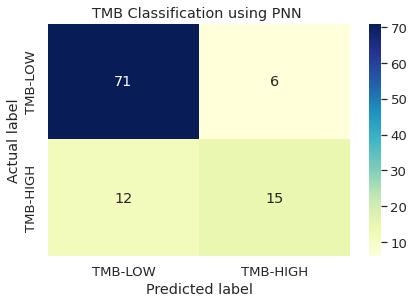

In [28]:
cnf_matrix = metrics.confusion_matrix(y_true, y_pred)


class_names=["TMB-LOW","TMG-HIGH"] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("bottom")
plt.tight_layout()
plt.title('TMB Classification using PNN ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

ax.xaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])
ax.yaxis.set_ticklabels(['TMB-LOW', 'TMB-HIGH'])